# ABoffsets_LSSTobs_calspec

Authors:  C. L. Adair, D. L. Tucker, with help from L. Jones, J. Carlin, and others

Created: 2024.11.15

Updated: 2025.01.29 (and it has cool stuff in here...I'm impressed with us)

Updated: 2025.05.07 (generalized for calspec stars beyond just C26202)

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc
import warnings
import matplotlib.patches as patches

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
import lsst.geom as geom
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

# rubin_sim-related packages
import rubin_sim.phot_utils as pt
import syseng_throughputs as st
from rubin_sim.data import get_data_dir

# Astropy-related packages
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, ImageNormalize
from astropy.stats import sigma_clipped_stats

# PIL package
from PIL import Image

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

/home/d/dltucker/WORK/GitHub/syseng_throughputs/syseng_throughputs/bandpassUtils.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1.2 Include user input

In [2]:
# Which repo, collection, instrument, and skymap to use.
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs
#collections = 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260'
#repo = '/repo/dp1'
#collections = 'LSSTComCam/DP1'

repo = '/repo/main'
collections = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'

#instrument = 'LSSTComCam'
#skymap_name = 'lsst_cells_v1'
#day_obs_start = 20241101
#day_obs_end = 20241231

instrument = 'LSSTCam'
skymap_name = 'lsst_cells_v1'
day_obs_start = 20250401
day_obs_end = 20251230


plotImages = True
verbose = 1         # 0, 1, 2, ...  Larger means more output to the screen.

# Which flux to use?  psfFlux or calibFlux?
fluxName = 'psfFlux'
fluxerrName = 'psfFluxErr'
#fluxName = 'calibFlux'
#fluxerrName = 'calibFluxErr'

# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# CalSpec star name
star_name = 'C26202'

# Which CalSpec spectrum FITS files to to use?
sedfile_dict = {'stiswfcnic_007' : '~/Downloads/c26202_stiswfcnic_007.fits', 
                'mod_008'        : '~/Downloads/c26202_mod_008.fits'
               }

# RA, DEC of calspec star in degrees (from `/home/d/dltucker/DATA/SynthMags/synthMagColorList.lsst_v1.9.calspec_20240603.added_info.csv`):
raDeg = 53.136845833333325
decDeg = -27.86349444444444

# List of filters to examine
flist = ['u','g','r','i','z','y']

# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

### 1.3 Define useful classes and functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cutout_im(butler, ra, dec, datasetType, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a preliminary_visit_image at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    wcs = butler.get('%s.wcs' % datasetType,**dataId)
    xy = geom.PointI(wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get(datasetType, parameters=parameters, **dataId)

    return cutout_image

In [5]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

In [6]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop = 0)

## 2. Calculate Synthetic AB magnitudes for CalSpec star, based on official filter bandpasses

### 2.1 Set up appropriate hardware and system from `syseng_throughputs`

***Check if the following code cell is appropriate for LSSTCam!!!:***

In [7]:
defaultDirs = st.setDefaultDirs()
if instrument == "LSSTComCam":
    #Change detectors from (default) LSST to ComCam (ITL CCDs)
    defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)


### 2.2 Calculate synthetic mags

In [8]:
mags = {}

# Loop through all SEDs in our sedfile dictionary
for sed_key in sedfile_dict:
    
    print(sed_key, sedfile_dict[sed_key])
    
    # Read the SED file associated with this SED
    sedfile = sedfile_dict[sed_key]
    seddata = fits.getdata(sedfile)

    # Transform the SED data into rubin_sim format
    wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
    flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm     
    sed = pt.Sed(wavelen=wavelen, flambda=flambda)
    
    # Loop over the filters, calculating the synthetic mags for each filter for this SED
    mags[sed_key] = []
    for f in flist:
        # Append the synthetic mag for this filter to this mags list for this SED
        mags[sed_key].append(sed.calc_mag(system[f]))
    # Convert list of synthetic mags for this SED into a numpy array
    mags[sed_key] = np.array(mags[sed_key])
    
    

stiswfcnic_007 ~/Downloads/c26202_stiswfcnic_007.fits
mod_008 ~/Downloads/c26202_mod_008.fits


### 2.3 Convert mags numpy arrays into a pandas dataframe

In [9]:
df_mags = pd.DataFrame(mags, index=flist)
df_mags

,stiswfcnic_007,mod_008
u,17.572834,17.586998
g,16.691932,16.692688
r,16.362017,16.361654
i,16.260196,16.259542
z,16.243700,16.243711
y,16.238819,16.238858


## 3. Query USDF Butler for observations of CalSpec star

### 3.1 Instantiate Butler

In [10]:
butler = dafButler.Butler(repo, collections=collections)

### 3.2 Find all the `visit_image`'s that overlap the sky position of CalSpec star

#### 3.2.1 Find the `dataId`'s for all `visit_image`'s in this repo/collection that overlap the RA, DEC of CalSpec star

In [11]:
datasetRefs = butler.query_datasets("visit_image", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

for i, ref in enumerate(datasetRefs):    
    print(i, ref.dataId)
    if ((verbose < 2) & (i >= 10)): 
        print("...")
        break
    

print(f"\nFound {len(datasetRefs)} visit_images")

0 {instrument: 'LSSTCam', detector: 44, visit: 2025090600260, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
1 {instrument: 'LSSTCam', detector: 49, visit: 2025090600252, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
2 {instrument: 'LSSTCam', detector: 51, visit: 2025090600256, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
3 {instrument: 'LSSTCam', detector: 51, visit: 2025090600266, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
4 {instrument: 'LSSTCam', detector: 51, visit: 2025090600280, band: 'r', day_obs: 20250906, physical_filter: 'r_57'}
5 {instrument: 'LSSTCam', detector: 52, visit: 2025082600442, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
6 {instrument: 'LSSTCam', detector: 52, visit: 2025082600445, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
7 {instrument: 'LSSTCam', detector: 52, visit: 2025090600254, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
8 {instrument: 'LSSTCam', detector: 52, visit: 2025090600259, ba

#### 3.2.2 Plot a cutouts one of the `(preliminary_)visit_image`'s

Find first r-band image from `datasetRefs`.

In [12]:
if plotImages:

    # Kudos to Claude-Sonnet-3.5 for finding a solution to identifying a 
    #  visit_image or preliminary_visit_image that has the necessary WCS info
    #  for plotting the images that follow.  (Current problems may be due to
    #  recent issues on USDF.)

    band_name = 'r'
    visit_image_type = ''
    
    for i, ref in enumerate(datasetRefs):
        if ref.dataId['band'] != band_name:
            continue
        
        visit = ref.dataId['visit']
        detector = ref.dataId['detector']
    
        try:
            visit_image = butler.get('visit_image', dataId={'visit': visit, 'detector': detector})
            visit_image_type = 'visit_image'
            visit_image.getWcs().getFitsMetadata()
            break  # Success with visit_image, exit loop
        except:
            try:
                visit_image = butler.get('preliminary_visit_image', dataId={'visit': visit, 'detector': detector})
                visit_image_type = 'preliminary_visit_image'
                visit_image.getWcs().getFitsMetadata()
                break  # Success with preliminary_visit_image, exit loop
            except:
                continue  # Both attempts failed, try next ref

    print(visit_image_type)
    print(ref.dataId)

preliminary_visit_image
{instrument: 'LSSTCam', detector: 51, visit: 2025090600280, band: 'r', day_obs: 20250906, physical_filter: 'r_57'}


In [13]:
if ( (plotImages) & (verbose > 1) ):
    visit_image_info = visit_image.getInfo()
    visit_info = visit_image_info.getVisitInfo()
    print(visit_info)
    summary_info = visit_image_info.getSummaryStats()
    print(summary_info)

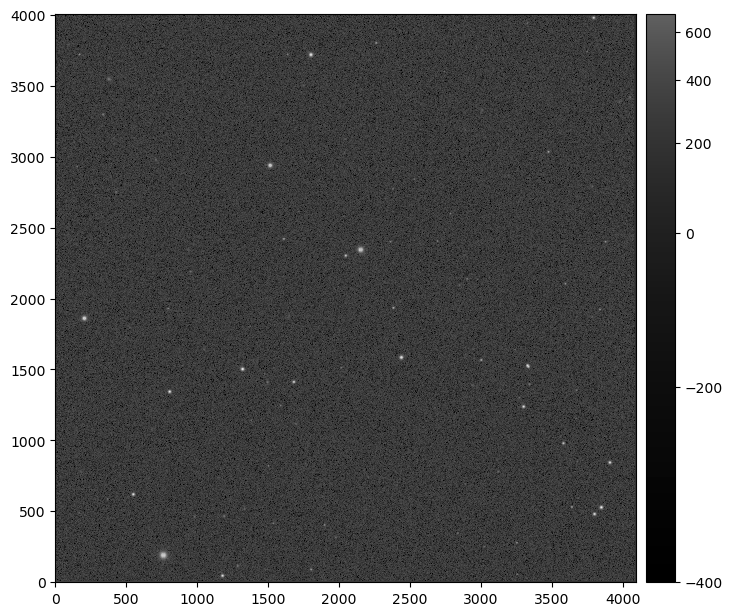

In [14]:
if plotImages:
    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(visit_image.image)
    plt.show()

In [15]:
if plotImages:
    try:
        # Create cutout image...
        cutoutsize = 501 #Defining the size of the cutout box in pixels
        #cutout_visit_image = cutout_im(butler, raDeg, decDeg, 'preliminary_visit_image', visit, detector, cutoutSideLength=cutoutsize)
        cutout_visit_image = cutout_im(butler, raDeg, decDeg, visit_image_type, visit, detector, cutoutSideLength=cutoutsize)

        # Plot cutout image...
        fig = plt.figure()
        display = afwDisplay.Display(frame=fig)
        display.scale('asinh', 'zscale')
        display.mtv(cutout_visit_image.image)
        plt.show()
    except:
        print("Target might be too close to the edge of this visit_image")
        print("Continuing...")

Target might be too close to the edge of this visit_image
Continuing...


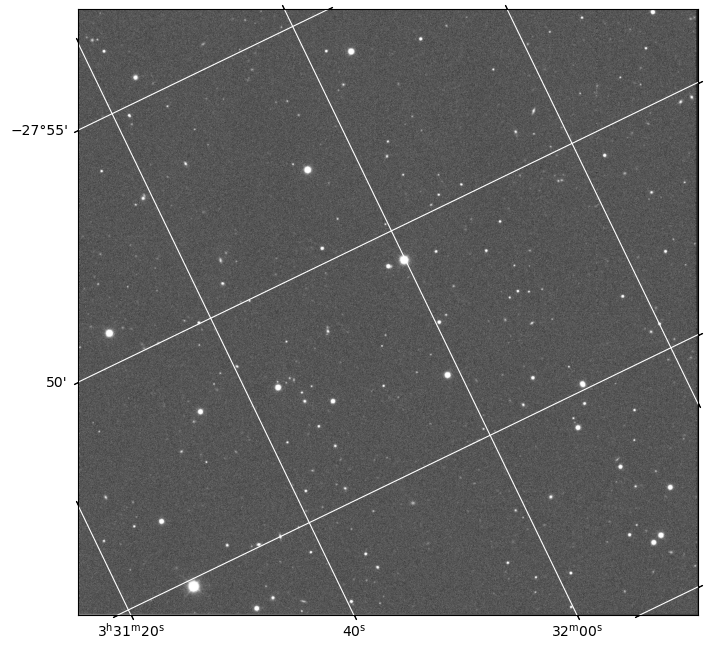

In [16]:
if plotImages:
    fig = plt.figure()
    plt.subplot(projection=WCS(visit_image.getWcs().getFitsMetadata()))
    calexp_extent = (visit_image.getBBox().beginX, visit_image.getBBox().endX,
                     visit_image.getBBox().beginY, visit_image.getBBox().endY)
    im = plt.imshow(visit_image.image.array, cmap='gray', vmin=-200.0, vmax=400,
                    extent=calexp_extent, origin='lower')
    plt.grid(color='white', ls='solid')
    #plt.xlabel('Right Ascension')
    #plt.ylabel('Declination')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

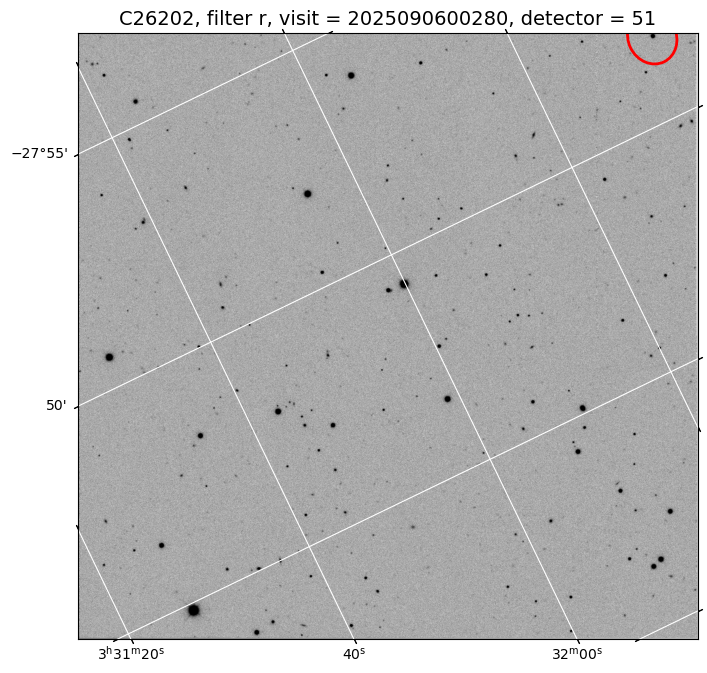

In [17]:
if plotImages:

    # Kudos to Co-Pilot for the following code...
    
    # Your existing setup
    fig = plt.figure()
    ax = plt.subplot(projection=WCS(visit_image.getWcs().getFitsMetadata()))
    calexp_extent = (visit_image.getBBox().beginX, visit_image.getBBox().endX,
                     visit_image.getBBox().beginY, visit_image.getBBox().endY)
    im = ax.imshow(visit_image.image.array, cmap='gray_r', vmin=-200.0, vmax=400,
                   extent=calexp_extent, origin='lower')
    ax.grid(color='white', ls='solid')
    #ax.set_xlabel('Right Ascension')
    #ax.set_ylabel('Declination')
    plt.xlabel('')
    plt.ylabel('')

    # Add a title
    plot_title = """%s, filter %s, visit = %d, detector = %d""" % \
                    (star_name, band_name, visit, detector)
    ax.set_title(plot_title, fontsize=14, color='black')

    # Add a circle around the star (in sky coordinates)
    circle = patches.Circle((raDeg, decDeg), radius=0.01,  # adjust radius as needed
                            transform=ax.get_transform('world'),
                            edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(circle)

    plt.show()


#### 3.2.3 Create a pandas Dataframe containing the `recalibrated_star_detector` (formerly `sourceTable`) info for all these `(preliminary_)visit_image`'s

Now, loop over the `datasetRefs` again, but this time grab the contents of the `recalibrated_star_detector` table for each `ref` and combine into all into one big pandas DataFrame.  

In [18]:
src_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('recalibrated_star_detector', dataId=dataId)
    src_list.append(src.to_pandas())

    if ((verbose >= 2) | (i < 10)): 
        print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(src)} sources.")
    if ((verbose < 2) & (i == 10)): 
        print("...")

src_all = pd.concat(src_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(src_all)} sources.")


0 Visit 2025090600260, Detector 44:  Retrieved catalog of 953 sources.
1 Visit 2025090600252, Detector 49:  Retrieved catalog of 587 sources.
2 Visit 2025090600256, Detector 51:  Retrieved catalog of 943 sources.
3 Visit 2025090600266, Detector 51:  Retrieved catalog of 1093 sources.
4 Visit 2025090600280, Detector 51:  Retrieved catalog of 499 sources.
5 Visit 2025082600442, Detector 52:  Retrieved catalog of 2478 sources.
6 Visit 2025082600445, Detector 52:  Retrieved catalog of 2514 sources.
7 Visit 2025090600254, Detector 52:  Retrieved catalog of 913 sources.
8 Visit 2025090600259, Detector 52:  Retrieved catalog of 889 sources.
9 Visit 2025090600253, Detector 53:  Retrieved catalog of 727 sources.
...

Total combined catalog contains 197526 sources.


Let's look at the result:

In [19]:
src_all

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter,sourceId
0,53.201270,-27.841398,0,3788.175341,28.706222,1.856643,1.005068,53.201270,-27.841398,0.000082,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770565
1,53.149934,-27.814036,0,2834.245394,31.665411,1.443259,1.008312,53.149934,-27.814036,0.000066,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770566
2,53.003777,-27.735855,0,114.431328,38.654726,0.502259,0.471090,53.003777,-27.735855,0.000024,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770567
3,53.007181,-27.738152,0,182.264101,45.763033,0.192874,0.188637,53.007181,-27.738152,0.000009,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770568
4,53.074386,-27.774469,0,1436.538958,47.768192,0.031900,0.028608,53.074386,-27.774469,0.000002,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197521,53.310490,-27.852761,25139291490354512,3018.873047,3943.664456,0.147905,0.151178,53.310490,-27.852761,0.000007,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355113
197522,53.309784,-27.854039,25139291490354512,2993.299978,3942.660105,0.264119,0.359438,53.309784,-27.854039,0.000017,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355114
197523,53.310774,-27.855343,25139291490354512,2978.196121,3966.536255,0.579090,0.568027,53.310774,-27.855343,0.000028,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355115
197524,53.316249,-27.840679,25139291490354515,3254.752492,3939.704297,1.496892,1.868746,53.316249,-27.840679,0.000089,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355117


### 3.3 Extract only those rows containing CalSpec star from the src_all catalog

In [20]:
# Based on code retrieved from Claude-3.5-Sonnet

# Create a mask to cull sources with "bad" measurements.
mask = (~src_all.pixelFlags_bad) & (~src_all.pixelFlags_saturated) & \
        (~src_all.extendedness_flag) & (src_all.detect_isPrimary)

# Apply mask, keeping only the "good" measurements of `src_all`
src_all_cleaned = src_all[mask]

# Create SkyCoord object for the coordinates of CalSpec star
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

# Create SkyCoord object for all points in the dataframe
df_coords = SkyCoord(ra=src_all_cleaned['ra'].values*u.degree, 
                     dec=src_all_cleaned['dec'].values*u.degree)

# Calculate separations
separations = ref_coord.separation(df_coords)

# Create mask for points within 3.0 arcseconds
mask_sep = separations < 3.0*u.arcsec

# Get filtered dataframe
nearby_good_df = src_all_cleaned[mask_sep]

# If you want to include the separations in the result
orig_columns = nearby_good_df.columns
nearby_good_df = src_all_cleaned[mask_sep].copy()
nearby_good_df['separation_calspec'] = separations[mask_sep].arcsec

# Find (and keep) the closet match within the match radius
best_df = nearby_good_df.sort_values('separation_calspec').drop_duplicates(subset=orig_columns, keep='first')


Add mag_obs and mag_obsErr columns:

In [21]:
# Flux in nano-Janskys to AB magnitudes:
best_df['mag_obs'] = -2.5*np.log10(best_df[fluxName]) + 31.4

# Flux error in nano-Janskys to AB magnitude error:
# Factor of 2.5/math.log(10) is explained here:  https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does
best_df['mag_obsErr'] = 2.5/math.log(10)*best_df[fluxerrName]/best_df[fluxName]

Display `visit`, `detector`, `band`, fluxName, fluxerrName, `mag_obs`, `mag_obsErr`, and `separation_calspec` from best_df, sorted by `visit` and `band`:

In [22]:
# Set pandas to show all rows...
if verbose > 2:
    pd.set_option("display.max_rows", None)

In [23]:
best_df[['visit', 'detector', 'band', fluxName, fluxerrName, 'mag_obs', 'mag_obsErr', 'separation_calspec']].sort_values(['visit', 'band'])

,visit,detector,band,psfFlux,psfFluxErr,mag_obs,mag_obsErr,separation_calspec
44039,2025071200713,92,r,1.033441e+06,1114.425537,16.364285,0.001171,0.622803
44780,2025071200714,92,r,1.035116e+06,1089.203003,16.362526,0.001142,0.613810
45761,2025071200735,92,z,1.155573e+06,1458.196533,16.243006,0.001370,0.611206
46948,2025071200736,92,z,1.160870e+06,1487.478760,16.238041,0.001391,0.617256
48177,2025071200737,92,z,1.160318e+06,1489.584717,16.238558,0.001394,0.595858
...,...,...,...,...,...,...,...,...
177075,2025090600281,98,r,1.036116e+06,1180.093018,16.361479,0.001237,0.608872
185638,2025090600282,99,r,1.030479e+06,1226.104126,16.367401,0.001292,0.625393
177946,2025090600283,98,r,1.040451e+06,1197.458618,16.356945,0.001250,0.597115
41302,2025090600284,91,r,1.043694e+06,1156.316528,16.353565,0.001203,0.585050


In [24]:
print("""Number of rows:  %d""" % (len(best_df['visit'])))

Number of rows:  125


In [25]:
# Reset pandas to its default maximum rows to print to screen
if verbose > 2:
    pd.reset_option("display.max_rows")

***Do we need to do any further masking/culling in the above table before proceeding?***

## 4. Measure differences between the calibrated observed magnitudes and the LSST Synthetic Mags for CalSpec star

In [26]:
# Group by the 'band' column in best_df calculate the counts of 'band' for each group
count_df = best_df.groupby('band')['mag_obs'].count().reset_index()

# Rename the columns for clarity
count_df = count_df.rename(columns={'mag_obs': 'n_band'})

if verbose > 2:
    count_df

In [27]:
# Group by the 'band' column in beset_df and calculate the median of 'mag_obs' for each group
median_df = best_df.groupby('band')['mag_obs'].median().reset_index()

# Rename the columns for clarity
median_df = median_df.rename(columns={'mag_obs': 'median_mag_obs'})

if verbose > 2:
    median_df

In [28]:
# Merge the count_df and merge_df dataframes based on the filter band name
combined_df = pd.merge(count_df, median_df, left_on='band', right_on='band')

if verbose > 2:
    combined_df

In [29]:
# Reset the df_mags index to turn the keys into a column
df_mags_reset = df_mags.reset_index()

# Merge the dataframes based on the filter name
combined_df = pd.merge(combined_df, df_mags_reset, left_on='band', right_on='index')

if verbose > 2:
    combined_df

In [30]:
# Calculate the differences and add the new columns
#combined_df['offset_stis'] = combined_df['median_mag_obs'] - combined_df['stiswfcnic_007']
#combined_df['offset_mod'] = combined_df['median_mag_obs'] - combined_df['mod_008']

for sed_key in sedfile_dict:
    offset_name = """offset_%s""" % (sed_key)
    combined_df[offset_name] = combined_df['median_mag_obs'] - combined_df[sed_key]


if verbose > 2:
    combined_df

In [31]:
# Output final cleaned-up results...

# Define the desired order of 'band'
order = ['u', 'g', 'r', 'i', 'z', 'y']

# Remove the 'index' column
combined_df = combined_df.drop(columns=['index'])

# Reorder the dataframe based on the 'band' column
combined_df['band'] = pd.Categorical(combined_df['band'], categories=order, ordered=True)
combined_df = combined_df.sort_values('band').reset_index(drop=True)

combined_df

,band,n_band,median_mag_obs,stiswfcnic_007,mod_008,offset_stiswfcnic_007,offset_mod_008
0,g,22,16.704891,16.691932,16.692688,0.012959,0.012203
1,r,30,16.362690,16.362017,16.361654,0.000673,0.001036
2,i,36,16.239456,16.260196,16.259542,-0.020740,-0.020086
3,z,37,16.242386,16.243700,16.243711,-0.001314,-0.001325


**Let's stop here for now:**

In [32]:
raise StopExecution

## 5. Sandbox